# การตัดสินใจด้วยต้นไม้

**จุดประสงค์การเรียนรู้**

1. รู้จักวิธีการ Decision tree และทราบว่ามีวิธีการตัดสินใจต่างจาก Linear model (Linear/Logistic Regression) ในคาบที่ผ่านมาอย่างไร
2. เทรนและทดสอบ Decision tree ได้
3. ตระหนักถึงปัญหา overfit และ underfit ของโมเดลกับข้อมูล
4. สามารถใช้ `GridSearchCV` ในการลองเทรนโมเดลที่การตั้งค่าต่าง ๆ


ในบทนี้ เราจะยังคงใช้ชุดข้อมูลเดิมจากบทที่ผ่านมา คือ [Car Evaluation](https://archive.ics.uci.edu/dataset/19/car+evaluation) ซึ่งเป็นชุดข้อมูลเกี่ยวกับการประเมินค่ารถ

In [3]:
%pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo
car_evaluation = fetch_ucirepo(id=19)   # fetch dataset
X = car_evaluation.data.features        # data (as pandas dataframes)
y = car_evaluation.data.targets

ชุดข้อมูล Car Evaluation มีตัวแปรดังต่อไปนี้

|คอลัมน์| ความหมาย | ค่าที่เป็นไปได้ |
|:--|:--|:-- |
|buying|	ราคาซื้อ | vhigh, high, med, low |
|maint | ค่าบำรุงรักษา		| vhigh, high, med, low |
|doors | จำนวนประตูรถ	| 2, 3, 4, 5more |
|persons | จำนวนผู้โดยสาร  | 2, 4, more |
|lug_boot	| ความจุท้ายรถ  | small, med, big |
|safety| ประมาณการความปลอดภัยของรถ  | low, med, high |
|class| ระดับการประเมินซึ่งแสดงถึง Car's Acceptability  | unacc, acc, good, vgood |


In [ ]:
y.value_counts()

class
unacc    1210
acc       384
good       69
vgood      65
dtype: int64

## เตรียมข้อมูลให้พร้อม

ก่อนอื่น แบ่งข้อมูล train/test โดยให้สัดส่วน 30% เป็นของข้อมูล test

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

จากนั้น แปลงทุกคอลัมน์ของตัวแปรต้นให้เป็นตัวเลข ด้วย `OrdinalEncoder` เนื่องจากทุกคอลัมน์เป็นค่าที่มีลำดับ โดยวิธีการใช้ `OrdinalEncoder` เหมือนกับในบทที่ผ่านมา

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ord = OrdinalEncoder(categories=
     [['low','med','high','vhigh'],  # ลำดับของค่าในคอลัมน์ buying
      ['low','med','high','vhigh'],  # ลำดับของค่าในคอลัมน์ maint
      ['2', '3', '4', '5more'],      # ลำดับของค่าในคอลัมน์ doors
      ['2', '4', 'more'],            # ลำดับของค่าในคอลัมน์ persons
      ['small','med','big'],         # ลำดับของค่าในคอลัมน์ lug_boot
      ['low','med','high']]          # ลำดับของค่าในคอลัมน์ safety
)
ord.set_output(transform='pandas')
X_train_new = ord.fit_transform(X_train)
X_train_new

,buying,maint,doors,persons,lug_boot,safety
1468,0.0,2.0,2.0,1.0,0.0,1.0
152,3.0,2.0,1.0,1.0,2.0,2.0
1119,1.0,1.0,1.0,1.0,1.0,0.0
1252,1.0,0.0,2.0,1.0,0.0,1.0
556,2.0,2.0,0.0,1.0,2.0,1.0
...,...,...,...,...,...,...
1122,1.0,1.0,1.0,1.0,2.0,0.0
1346,0.0,3.0,1.0,2.0,1.0,2.0
1406,0.0,2.0,0.0,0.0,0.0,2.0
1389,0.0,3.0,3.0,1.0,1.0,0.0


## เทรนโมเดล Decision tree

ก่อนอื่น ให้ศึกษาหลักการเบื้องต้นของโมเดลต้นไม้ตัดสินใจ (Decision tree) จาก [Slides (คลิกเพื่อเปิด)](https://docs.google.com/presentation/d/1qCZki7tNQGmRlzqnQchn2i2f5ED2gRtw3mObhiRy3yU/edit?usp=sharing) โดยในส่วนของการเขียนโค้ด เราจะใช้ `DecisionTreeClassifier` ([คู่มือ](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)) ของ Scikit-learn ซึ่งมีรูปแบบใช้งานไม่ต่างจาก `LinearRegression/LogisticRegression` มากนัก ยกเว้นโมเดลจะมีการกำหนดค่าพารามิเตอร์ที่แตกต่างกัน

สำหรับรูปแบบการใช้งาน และพารามิเตอร์ที่กำหนดได้ในเบื้องต้น เป็นดังนี้

```python
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(
            criterion='gini' หรือ 'entropy',
            max_depth=จำนวนชั้นการตัดสินใจ,
            min_samples_split=จำนวนจุดข้อมูลขั้นต่ำที่จะทำการแตกกิ่ง,
            min_samples_leaf=จำนวนจุดข้อมูลขั้นต่ำที่ปลายกิ่งต้องมี,
            random_state=ค่าซีดล็อคผลการสุ่มถ้ามี)
```

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion='gini',
                            max_depth=3,
                            min_samples_split=2,
                            min_samples_leaf=1,
                            random_state=123)

dt.fit(X_train_new, y_train)

DecisionTreeClassifier(max_depth=3, random_state=123)

## ประเมินประสิทธิภาพของโมเดล



In [ ]:
from sklearn.metrics import accuracy_score
y_train_pred = dt.predict(X_train_new)
acc = accuracy_score(y_train, y_train_pred)
print(f'Accuracy on the training set = {acc:.4f}')

Accuracy on the training set = 0.8147


In [ ]:
X_test_new = ord.transform(X_test)
y_test_pred = dt.predict(X_test_new)
acc = accuracy_score(y_test, y_test_pred)
print(f'Accuracy on the test set = {acc:.4f}')

Accuracy on the test set = 0.7842


หากจะลองป้อนข้อมูล 1 example เข้าไป เพื่อดูว่าโมเดลทำนายอะไรออกมา ก็ทำได้ ยกตัวอย่างเช่น ป้อน


|'buying'|'maint'| 'doors'|'persons'|'lug_boot'|'safety'|
|:--|:--|:--|:--|:--|:--|
|'low'|   'vhigh'| '2'|    '4'|      'small'|   'low'|

จะพบว่าทำนาย `unacc` ออกมาดังโค้ดด้านล่างนี้

In [ ]:
import pandas as pd
sample_input = pd.DataFrame([['low',   'vhigh', '2',    '4',      'small',   'low']],
                     columns=['buying','maint', 'doors','persons','lug_boot','safety'])
print(f'Before OrdinalEncoder:\n {sample_input}')
sample_input = ord.transform(sample_input)
print(f'Input to the model:\n {sample_input}')
prediction = dt.predict(sample_input)
print(f'Model prediction:\n{prediction}')

Before OrdinalEncoder:
   buying  maint doors persons lug_boot safety
0    low  vhigh     2       4    small    low
Input to the model:
    buying  maint  doors  persons  lug_boot  safety
0     0.0    3.0    0.0      1.0       0.0     0.0
Model prediction:
['unacc']


ผลดังกล่าว สอดคล้องกับกราฟจาก `plot_tree` ในห้วข้อถัดไปหรือไม่?

## การแปลผลการติดสินใจ

โมเดล Decision tree ตัดสินใจโดยการหากฎ IF/ELSE จากข้อมูล  ที่สามารถแบ่งข้อมูลได้ดีที่สุด เราสามารถตรวจสอบกฎดังกล่าว ที่ได้จากการเทรน ดังนี้

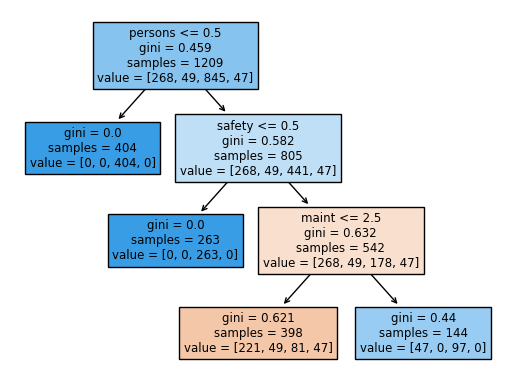

In [ ]:
from sklearn.tree import plot_tree
feature_names = dt.feature_names_in_  # ชื่อของคอลัมน์ที่นำมาเทรนโมเดล
plot_tree(dt,   # ตัว DecisionTreeClassifier ที่เทรนแล้ว
          filled=True, # ระบายสีลงในแผนภาพ
          feature_names=feature_names # ใส่ชื่อคุณลักษณะหรือคอลัมน์ของข้อมูลที่ใช้ตัดสินใจ)
);

จากกราฟ ลำดับการตัดสินใจในแต่ละ node ว่าจะเริ่มตัดสินใจจากตัวแปรใดบ้าง รวมถึงตัดสินใจแบ่งด้วยค่าเท่าไรนั้น เช่น `persons<=0.5` หรือ  `maint<=2.5` เป็นสิ่งที่เรียนรู้จากข้อมูล training

**วิธีอ่านกราฟ:**

ลูกศรที่ออกจากแต่ละ node ของกราฟ *หากชี้ซ้าย แปลว่า จริง และหากชี้ขวา แปลว่า เท็จ*

ในแต่ละโหนดของกราฟ

1. คอลัมน์ที่จะใช้ในการตัดสินใจที่ node นั้น ๆ เช่น `persons<=0.5`
2. สถานะของค่า impurity ที่ node นั้น ๆ เช่น `gini=0.459` (เป็นค่าก่อนการใช้กฎการตัดสินใจจากข้อ 1.)
3. จำนวนข้อมูลทั้งหมดที่ node นั้น ๆ
4. จำนวนข้อมูลจากข้อ 3 แจกแจงจำนวนตาม class ใน node นั้น ๆ ตามลำดับ `['acc', 'good', 'unacc', 'vgood']` (ดูลำดับจาก `dt.classes_`)




In [ ]:
dt.classes_  # ค่า value= ในกราฟ จะเรียงลำดับตาม dt.classes_

array(['acc', 'good', 'unacc', 'vgood'], dtype=object)

## ปัญหา overfit และ underfit

ปัญหาที่ Decision tree มักผจญเสมอ ก็คือปัญหา overfit และ underfit อันที่จริงปัญหานี้ เป็นปัญหาสำคัญที่พบได้กับทุก**โมเดล ที่สามารถสร้างรูปแบบการตัดสินใจที่ซับซ้อนมากเกินไปหรือน้อยเกินไป** ดังนั้น เราลองมาทำความเข้าใจว่า มันคือปัญหาอะไรกันแน่

เพื่อให้เห็นภาพ เราจะใช้โค้ดตั้งต้นเดิม แต่เปลี่ยนไปใช้ชุดข้อมูล [Dry Bean](https://archive.ics.uci.edu/dataset/602/dry+bean+dataset) (ชุดข้อมูลจำแนกพันธุ์ถั่วแห้ง) ซึ่งมีความยากกว่าชุดข้อมูล Car Evaluation โดยตัด `OrdinalEncoder` ทิ้งไป เพราะชุดข้อมูล Dry Bean เป็นตัวเลขทั้งหมดอยู่แล้ว

สำหรับชุดข้อมูล Dry Bean เราจะมีข้อมูลถั่วทั้งหมด 13,611 เมล็ด ซึ่งแต่ละเมล็ดมี 16 คุณลักษณะ เพื่อใช้จำแนกชนิดถั่วออกเป็น 7 ประเภท

นักศึกษาไม่จำเป็นต้องทำความเข้าใจว่าแต่ละคอลัมน์ของชุดข้อมูล Dry Bean คืออะไร แต่ให้ลองรันโค้ดด้านล่างนี้ และทดสอบปรับค่า `max_depth` ที่ค่าต่าง ๆ เช่น

`max_depth = 2, 3, 4, ..., 10, 100`

แล้วให้สังเกตุค่า Accuracy ของ training set เทียบกับ test set

In [2]:
# โค้ดในบล๊อคนี้ เป็นโค้ดที่สมบูรณ์ในตัว
%reset -f
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

data = fetch_ucirepo(id=602)   # fetch dataset
X = data.data.features        # data (as pandas dataframes)
y = data.data.targets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

dt = DecisionTreeClassifier(criterion='gini',
                            max_depth=30,   ### ลองแก้ตรงนี้
                            min_samples_split=2,
                            min_samples_leaf=1,
                            random_state=123)

# เริ่มเทรน
dt.fit(X_train, y_train)

# Training set
y_train_pred = dt.predict(X_train)
acc_train = accuracy_score(y_train, y_train_pred)

# Test set
y_test_pred = dt.predict(X_test)
acc_test = accuracy_score(y_test, y_test_pred)

# Print accuracy
print(f'Accuracy: train = {acc_train:.4f}, test = {acc_test:.4f}')

Accuracy: train = 0.9648, test = 0.9067


<figure>
<img src="https://raw.githubusercontent.com/kasemsit/269382/main/fig/decision_tree_max_depth.svg" width=100%>
<figcaption>กราฟเปรียบเทียบค่า accuracy ของชุดข้อมูล train และ test ที่ค่า max_depth ค่าต่าง ๆ ของโมเดล</figcaption>
</figure>

จากกราฟ จะสามารถสังเกตุผลของการปรับค่า `max_depth` ดังนี้

1. ที่ค่า `max_depth` น้อยมาก ๆ เช่น `max_depth` ได้ accuracy ของข้อมูล train และ test เท่ากับ 82.5% และ 82.2% ตามลำดับ โดยที่ค่าประสิทธิภาพนี้ต่ำเมื่อเทียบกับส่วนทางขวาของกราฟ สถานการณ์นี้บ่งบอกว่าเกิดปัญหา underfit เพราะจำนวนชั้นของกฎต้นไม้น้อยเกินไป
 - **underfit** = โมเดลไม่ซับซ้อนพอที่จะจดจำลักษณะของข้อมูลที่ซับซ้อนได้ (= poor generaliztion)
2. ที่ `max_depth=25` มีค่า accuracy ของ train ประมาณ 100% หมายความว่าโมเดลจำข้อมูล train ได้ทุกตัว แต่กลับได้ accuracy ของข้อมูล test เพียง 89.9% ความห่างกันอย่างมากระหว่างผลของ training set กับ test set บ่งบอกถึงปัญหา overfit เพราะจำนวนชั้นของกฎต้นไม้มากเกินไป
 - **overfit** = โมเดลซับซ้อนมากเกินไป จนจดจำข้อมูลที่ใช้ฝึกสอนได้ดี แต่กลับนำความรู้ไปใช้กับข้อมูลที่ไม่เคยเห็นได้แย่ (= poor generaliztion)
3. ที่ค่า `max_depth=8` ได้ค่า accuracy ของ test set สูงสุดเท่าที่เป็นไปได้คือ 90.9% แม้ว่า training set จะได้เพียง 94.1%

>**Note:** ลักษณะของกราฟข้างต้น เรียกว่า **Bias-variance tradeoff** ซึ่งเป็นความกล้ำกลืนที่ต้องเลือกระหว่างโมเดลที่ซับซ้อน แต่มีความแปรปรวน (Variance) ในการทำนายกับข้อมูลที่ไม่เคยเห็นมาก่อน กับ โมเดลที่เรียบง่ายตัดสินใจไม่ซับซ้อน แต่ก็อาจจะโง่เกินไปเพราะอคติ (Bias) ในตัว
>**หมายเหตุ:** หากไปคำว่า Bias-variance tradeoff ในอินเตอร์เน็ต จะพบกราฟที่กลับหัวกับกราฟข้างต้น เนื่องจากโดยปกติมักจะแสดงแกนตั้งด้วยค่า Error ของการทำนาย แทนที่จะเป็นค่า Accuracy อย่างเช่นที่แสดงให้นักศึกษาเห็น


>Decision tree มีค่าต่าง ๆ มากมายที่ต้องกำหนดเอง ได้แก่ `max_depth` ที่ได้ทดลองปรับเองจากหัวข้อก่อนหน้า เราเรียกค่าที่เราต้องกำหนดเอง โดยที่โมเดลไม่ได้เรียนรู้จากข้อมูลนี้ว่า **hyper-parameter ของโมเดล** เพื่อไม่ให้สับสนกับ **parameter ของโมเดล** ที่ต้องเรียนรู้จากข้อมูล เช่นกฏ `persons<=0.5` ใน Decision tree หรือพารามิเตอร์ $w$ และ $b$ ของ Linear/Logistic regression


**คำถาม:**

1. โมเดลอื่น ๆ นอกจาก Decision tree เกิดปัญหา overfit/underfit ได้ด้วยหรือไม่?
  - **ตอบ:** มีเช่นกัน
2. จากกราฟ เราควรเลือกค่า `max_depth` ที่ค่าเท่าไรดีล่ะ?
  - **ตอบ:** ควรเลือก `max_depth=8` เพราะดูเป็นจุดที่เป็นทางสายกลาง เพราะจำนวนชั้นของกฎต้นไม้ไม่มากหรือน้อยเกินไป ซึ่งถ้ากล่าวตามจริง โดยทั่วไป เราแคร์ที่โมเดลจะทำนายได้ดีกับข้อมูลที่ไม่เคยเห็น (test set)
3. จากคำถามข้อ 2. สิ่งที่เราทำจนกว่าจะได้ค่า `max_depth=8` คือ ลองเทรน `max_depth` ที่ค่าต่าง ๆ กับข้อมูล `X_train` แล้วเอามาทดสอบกับข้อมูล `X_test` จนกว่าจะพบ `max_depth` ที่มีประสิทธิภาพกับ `X_test` ดีที่สุด นักศึกษาคิดว่า จริง ๆ **มันแฟร์หรือไม่**ที่จะบอกว่า `max_depth=8` ที่พบนั้นดีจริง ๆ **และเพราะอะไร**
  - **ตอบ:** ไม่แฟร์เลย เพราะเท่ากับว่าเราใช้ `X_test` ในการ tune หาค่า `max_depth` ซึ่งสุดท้ายแล้วจะเกิดปัญหา overfit กับค่า `max_depth` เองก็เป็นได้ กล่าวคือโมเดลที่เทรนด้วยค่า `max_depth=8` อาจจะใช้ไม่ได้กับข้อมูลอื่น ๆ  ในความเป็นจริง `X_test` เป็นข้อมูลที่ไม่ควรถูกแตะต้องในกระบวนการสอนโมเดล ซึ่งวิธีการแก้ไขคือ เราควรมีข้อมูล 3 กลุ่ม แทนที่จะมีแค่ 2 กลุ่ม (train/test) เหมือนที่เราทำที่ผ่านมา โดยหน้าที่ของข้อมูล 3 กลุ่มนี้ คือ
    - **Training set** - ใช้ฝึกสอนโมเดล (เหมือนกับ Training set เดิม)
    - **Validation set** - ใช้ทดสอบประสิทธิภาพของโมเดลในเบื้องต้น เพื่อปรับจูนค่า hyper-parameter ต่าง ๆ เช่น `max_depth` ซึ่งข้อมูลเซตนี้เป็นเซตใหม่ที่อาจแบ่งมาจาก Training set เดิม
    - **Blind test set** - เป็นชุดข้อมูลที่เก็บไว้ทดสอบประสิทธิภาพจริง ๆ ในขั้นสุดท้าย

## ลองค่าต่าง ๆ ด้วย `GridSearchCV`

การปรับค่า hyper-parameter ต่าง ๆ หากจะลองผิดลองถูกทีละค่าก็ไม่สะดวกเท่าไร ดังนั้นจึงมีเครื่องมืออำนวยความสะดวกที่ช่วยทดสอบชุดของค่าเหล่านั้น โดยใช้ `GridSearchCV` [คู่มือ](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) ซึ่งรูปแบบการใช้งาน เป็นการนำ `GridSearchCV` ไปครอบหรือเรียกใช้ตัวโมเดลอีกที ดังรูปแบบต่อไปนี้

```python
from sklearn.model_selection import GridSearchCV

cv = GridSearchCV(โมเดล, ดิกชันนารีของค่า, refit=True)
```

โดยเมื่อสร้าง `cv` แล้ว ก็สามารถเรียกใช้ได้เหมือนโมเดลปกติ เช่น 

- `cv.fit(X_train, y_train)` และ 
- `cv.predict(X_test)`

ทั้งนี้ `GridSearchCV` จะเลือก hyperparameters ที่ดีที่สุด ที่ต่างจากวิธีการของเราอยู่บ้าง กล่าวคือ `GridSearchCV` จะใช้วิธีการ 5-fold cross validation (โดย default) ดังนี้

1. `cv.fit(X_train, y_train)` สุ่มแบ่งข้อมูล `X_train` เป็น 5 ส่วน (folds) 5 แบบ ดังตาราง

|  | Fold 1 | Fold 2 | Fold 3 | Fold 4 | Fold 5 |
|:--:|:--:|:--:|:--:|:--:|:--:|
| ข้อมูลสำหรับโมเดล 1 | X | O | O | O | O |
| ข้อมูลสำหรับโมเดล 2 | O | X | O | O | O |
| ข้อมูลสำหรับโมเดล 3 | O | O | X | O | O |
| ข้อมูลสำหรับโมเดล 4 | O | O | O | X | O |
| ข้อมูลสำหรับโมเดล 5 | O | O | O | O | X |

2. สร้างโมเดลจากการกำหนด hyper-parameter 1 แบบที่ต้องการลอง เช่น สมมติเลือก `max_depth=40, criterion='gini', min_samples_split=2` เป็นต้น

3. นำค่าข้อ 2. มาเทรนโมเดล 5 โมเดล โดยแต่ละโมเดลจะเทรนและทดสอบโดยใช้ข้อมูลต่างกันตามตารางข้อ 1 คือ เฉพาะส่วนที่เป็นสัญลักษณ์ O จะเป็น training set และส่วนที่เป็น X จะเป็น validation set (หรือชุดข้อมูลทดสอบในเบื้องต้น)

4. นำผลประสิทธิภาพของทั้ง 5 โมเดลมาเฉลี่ยรวม

5. กลับไปทำข้อ 2, 3, 4 อีกครั้ง โดยเปลี่ยนไปใช้ hyper-parameter ค่าอื่น จนครบทุกค่าที่ต้องการลอง โดยสุดท้ายแล้ว hyper-parameters ที่ดีที่สุดคือที่ให้ประสิทธิภาพที่วัดในข้อ 4 สูงที่สุด

6. เป็นขั้นตอนของการ Refit คือการนำ hyper-parameters ที่ดีที่สุดจากข้อ 5 มาเทรนกับข้อมูลทั้งชุด (`X_train`) (Fold 1 ถึง 5 ทั้งหมด) ซึ่งขั้นตอนนี้ระบุให้ทำด้วยการกำหนด `refit=True`


สำหรับโค้ดตัวอย่างการใช้ `GridSearchCV` ดูได้ตามด้านล่างนี้

In [3]:
from sklearn.model_selection import GridSearchCV

# สร้างโมเดลที่กำหนดค่าไว้บางส่วน
dt = DecisionTreeClassifier(
            min_samples_split=2,
            min_samples_leaf=1,
            random_state=123
)

# List of Dictionary of Hyper-parameters ที่ต้องการทดลองโดย GridSearchCV จะจับคู่กันทุกแบบ
param_grid = [
    {'max_depth':[6,8,10,12],
    'criterion':['gini']}
]

# สร้าง GridSearchCV เปล่า ๆ ครอบ DecisionTreeClassifier dt อีกที
cv = GridSearchCV(dt, param_grid, refit=True)

# ฝึกสอน GridSearchCV ซึ่งจะไปสอน dt อีกที ด้วย param_grid ค่าต่าง ๆ
cv.fit(X_train, y_train)
print(f'Best hyperparameters are {cv.best_params_}')

# การทำนาย (ใช้ cv ไม่ใช่ dt เพราะค่า hyperparameter ที่ดีที่สุด เก็บไว้ใน cv ไม่ใช่ dt)
y_train_pred = cv.predict(X_train)  # Prediction on training set
y_test_pred = cv.predict(X_test)    # Prediction on test set

# รายงานผล
acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)
print(f'Accuracy: train = {acc_train:.4f}, test = {acc_test:.4f}')

Best hyperparameters are {'criterion': 'gini', 'max_depth': 10}
Accuracy: train = 0.9648, test = 0.9067


จะเห็นว่า ผลลัพธ์ที่ได้อาจไม่ใช่ค่า `max_depth=8` เดียวกับค่าที่เราคิดว่าดีที่สุด นั่นเป็นเพราะ `GridSearchCV`แบ่งซอยข้อมูล `X_train` ไปเป็นหลาย validation set แล้วเฉลี่ยผลลัพธ์ 

